# Lab 3
This labs is about using CNN on MNIST data set which is a collection of handwritten digits.

In [2]:
# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# MIT introduction to deep learning package
#!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [3]:
#!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = "Xg2mJUP2iMIjlVOUSERvKB3IN"

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

# Set GPU for computation
if torch.cuda.is_available():
    print("Using GPU for computation")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using GPU for computation


In [ ]:
# start a first comet experiment for the first part of the lab
comet_ml.init(project_name="HLab3_NN")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, keras, torch, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/code4geoai/hlab3-nn/ce77063c6b73453b8c81286055846ba7



COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


# MNSIT Dataset
Lets load the dataset and display a few samples

In [5]:
transform = transforms.Compose([transforms.ToTensor()])# Convert images to PyTorch tensors
train_dataset = datasets.MNIST(root='./data', train = True, download=True, transform = transform)
test_dataset = datasets.MNIST(root ='./data', train=False , download=True, transform = transform)

100%|██████████| 9.91M/9.91M [00:17<00:00, 566kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 115kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 389kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [6]:
image,label = train_dataset[0]
print(f"Image Shape:{image.shape}, Label: {label}")
# This shows that our images are 28x28 pixels and have a single channel (grayscale)


Image Shape:torch.Size([1, 28, 28]), Label: 5


{'web': 'https://www.comet.com/api/image/download?imageId=54632454a1c2486b996fdf7ee7dab63a&experimentKey=ce77063c6b73453b8c81286055846ba7',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=54632454a1c2486b996fdf7ee7dab63a&experimentKey=ce77063c6b73453b8c81286055846ba7',
 'imageId': '54632454a1c2486b996fdf7ee7dab63a'}

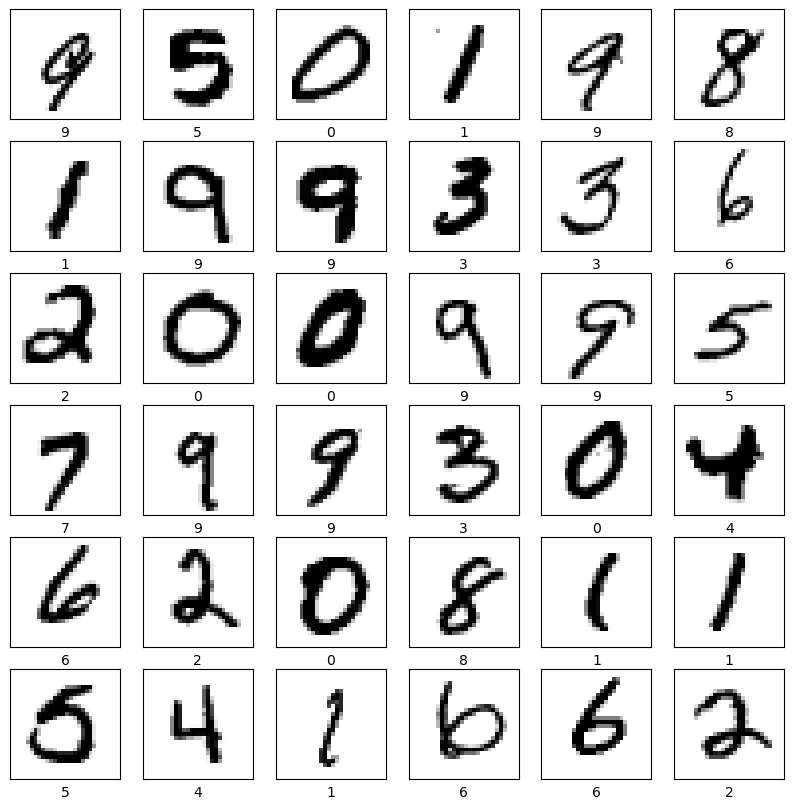

In [7]:
plt.figure(figsize = (10,10))
random_indices = np.random.choice(6000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    image_ind = random_indices[i]
    image,label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap = plt.cm.binary)
    plt.xlabel(label)
comet_model_1.log_figure(figure=plt)




# CNN for Hand Digits Classification:
Let first have a look at nn. Sequential 

In [8]:
def build_fc_model():
    fc_model = nn.Sequential(
        nn.Flatten(),  # Flatten the input
        nn.Linear(28 * 28, 128),  # Fully connected layer with 128 neurons
        nn.ReLU(),  # Activation function
         nn.Linear(128, 10)  # Output layer for 10 classes (digits 0-9)
    )
    return fc_model
fc_model_sequential = build_fc_model()

# Utilizaing the Subclasses in PyTorch

In [9]:
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(). __init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 =nn.Linear(128, 10)

    def forward(self,x):
        x = self.flatten(x)
        x = self.fc1(x)
        x= self.relu(x)
        x= self.fc2(x)
        return x
fc_model = FullyConnectedModel().to(device)

# Loss Function:  
The loss function calculates the loss during traning process. Loss Function 
$ L = (y' - y)^2 $ 
# Optimizer :
This defines how the model is updated based on the data it sees and the loss function. 
$w_{new} = w_{old} - \alpha \frac{\partial L}{\partial w}$

# Metric :
Here we can define matrics that we want to use to monitor the training and test steps. we will have a look at the accuracy, the fraction of the images that are correctly classified.



In [10]:
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_model.parameters(), lr = 0.1)

# Train the Model:
Lets load the data through DataLoader.

In [11]:
BATCH_SIZE =64
trainset_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
testset_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = False)

In [12]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0

        for images, labels in trainset_loader:
            images , labels = images.to(device), labels.to(device)
            # Clean the gradients before the backward pass
            optimizer.zero_grad()

            # Forward Pass
            outputs = fc_model(images)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backward pass and update the weights
            loss.backward()
            optimizer.step()

            #multiply the loss by the total number of images in the batch(batch_size)
            total_loss += loss.item() * images.size(0)

            #Calculate the accuracy 
            predicted = torch.argmax(outputs, dim=1) # Get the indices of the heighest number , explanation below
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)
        #compute metrices
        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            

outputs is typically the output from the final layer of your model.

For a classification task, this is usually a logits tensor of shape [batch_size, num_classes].

torch.argmax(outputs, dim=1) finds the index (class label) with the highest score (logit) along dimension 1 (i.e., across the classes) for each sample in the batch.

👉 So, predicted will contain the predicted class indices for each input in the batch.

predicted == labels performs an element-wise comparison, resulting in a Boolean tensor (True where the prediction is correct).

.sum() counts the number of correct predictions in the batch (because True is treated as 1).

.item() extracts the scalar value from the tensor (so you can add it to an integer).

👉 correct_pred accumulates the total number of correct predictions so far.

# Example
et’s say we are doing classification with 4 classes, and we’re making predictions on a batch of 3 samples.

🧠 outputs from the model:

outputs = torch.tensor([
    [2.5, 0.3, 0.2, 0.1],   # sample 1
    [0.1, 0.4, 0.3, 0.2],   # sample 2
    [0.05, 0.1, 0.9, 0.8]   # sample 3
])
Each row is one sample's output logits (not probabilities yet), and each column is a class (0, 1, 2, 3).

🔍 Step 1: Get predicted class using torch.argmax

predicted = torch.argmax(outputs, dim=1)
# 💡 What does this do?
It picks the index of the highest number in each row:

Row 1: [2.5, 0.3, 0.2, 0.1] → highest at index 0 → class 0

Row 2: [0.1, 0.4, 0.3, 0.2] → highest at index 1 → class 1

Row 3: [0.05, 0.1, 0.9, 0.8] → highest at index 2 → class 2

So,

predicted == tensor([0, 1, 2])
🏷️ Suppose the True Labels Are:

labels = torch.tensor([0, 3, 2])  # Actual classes for sample 1, 2, and 3
Now let’s compare predicted and labels:

Sample 1: predicted 0, true 0 → ✅ correct

Sample 2: predicted 1, true 3 → ❌ wrong

Sample 3: predicted 2, true 2 → ✅ correct

✅ Step 2: Count correct predictions

correct_pred += (predicted == labels).sum().item()
Breaking it down:

(predicted == labels) 
# => tensor([True, False, True])

(predicted == labels).sum() 
# => 2 (True counts as 1)

(predicted == labels).sum().item()
# => 2 (scalar integer)
So correct_pred += 2

🧮 Step 3: Count total samples

total_pred += labels.size(0)  # labels.size(0) = 3
So total_pred += 3

🎯 Final Accuracy:

accuracy = correct_pred / total_pred = 2 / 3 ≈ 0.666 or 66.6%

In [13]:
# Train the Model
EPOCHS = 5
train(fc_model, trainset_loader, loss_function,optimizer, EPOCHS) 
comet_model_1.end()

Epoch [1/5], Loss: 0.4492, Accuracy: 0.8779
Epoch [2/5], Loss: 0.2305, Accuracy: 0.9337
Epoch [3/5], Loss: 0.1731, Accuracy: 0.9502
Epoch [4/5], Loss: 0.1389, Accuracy: 0.9601


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : adjacent_tower_434
COMET INFO:     url                   : https://www.comet.com/code4geoai/hlab3-nn/ce77063c6b73453b8c81286055846ba7
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (7.49 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 


Epoch [5/5], Loss: 0.1159, Accuracy: 0.9666


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, keras, torch, tensorflow.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 2 metrics, params and output messages


Date 22 July
#  Evaluate the Accurracy on the Test dataset


In [14]:
def evaluate(model, dataloader, loss_function):
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0

    #Disable the gradient calculation for evaluation mode
    with torch.no_grad():
        for images, labels in testset_loader:
            images, labels = images.to(device), labels.to(device)

            # Feed the images into the model and get the predictions
            output = model(images)

            # Calculate the loss
            loss = loss_function(output,labels)

            #Calculate the test loss
            test_loss += loss.item() * images.size(0)

            # Make the predictions and determinte whether its correct or not
            predicted = torch.argmax(output, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

    # Compute the average loss and accuracy
    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

# Evaluate the Model
test_loss, test_acc = evaluate(fc_model, testset_loader, loss_function)
print(f"Test Accuracy :{test_acc:.4f}")

Test Loss: 0.1146, Test Accuracy: 0.9659
Test Accuracy :0.9659


# CNN for handwritten Digits Classification
Applying CNN for the same task of handwritten digits classification in Pytorch

The important thing to note in CNN is input shape and output shape
inputshape = (channel, H, W) in our case it becomes **(1,28,28)**
outputshape = (number of filters or featuremaps , H, W) 
Output shape is calculated form kernel_size and H/W as
[{(H or W) - K}/S]+1
So {(28 -3 )/1}+1
 25+1= 26

 So output Shape becomes = **(output_channel,26,26)** since our first layer nn.conv2d is (1,24,kernel_size=3) ,1 is input channel and 24 output so our output becomes ***(24,26,26)**
 Now Apply Maxpooling on this. Remember Maxpooling is normally a 2x2 filter so reduces the size by half.
 (24,26,26) ---> Maxpool ---> (24,13,13)
 
 Now at 2nd Conv2 Layer `nn.Conv2d(24,36, kernel_size=3)`  our input becomes **(24,13,13)** and we can calculate the output by the same formula 
 {(13-3)/1}+1 = 11 so output will be (36, 11,11) 
 input = (24,13,13)
 output (36,11,11)
Once Again Maxpool on (36,11,11) ----> Maxpool -----> (35,5,5) 
output shape after Maxpool_2 = (35,5,5)
Next is Flattening Layer so we multiply channel*H*W
and we get our first deep layer (36 * 5 *5 ,128) where as 128 are the number of neurons. 
The we have the activation function ReLU and finally another deep layer with 128 input neurons calssify the output in 10 classes.

## 🧠 CNN Layer-wise Explanation: Input/Output Shapes, Conv & Pooling

In CNN, the most important thing to understand is how the **input and output shapes** evolve at each layer.

---

### ✅ Input Shape Convention

- PyTorch uses: **(Channels, Height, Width)**  
- In our case, the input image is grayscale → **(1, 28, 28)**

---

### 🔁 Conv Layer 1: `nn.Conv2d(1, 24, kernel_size=3)`

- Applies **24 filters of size 3×3** to input
- Formula for output size (Height or Width):
  
  \[
  \text{Output} = \left( \frac{\text{Input Size} - \text{Kernel Size}}{\text{Stride}} \right) + 1 = \left( \frac{28 - 3}{1} \right) + 1 = 26
  \]

- So, output shape = **(24, 26, 26)**

---

### 🔽 Max Pooling 1: `nn.MaxPool2d(2, 2)`

- Typical 2×2 pooling reduces dimensions by half
- Output: **(24, 13, 13)**

---

### 🔁 Conv Layer 2: `nn.Conv2d(24, 36, kernel_size=3)`

- Input: **(24, 13, 13)**
- Output size calculation:

  \[
  \left( \frac{13 - 3}{1} \right) + 1 = 11
  \]

- Output shape: **(36, 11, 11)**

---

### 🔽 Max Pooling 2

- Input: **(36, 11, 11)**
- Output after 2×2 pooling: **(36, 5, 5)**

---

### 🔁 Flatten Layer: `nn.Flatten()`

- Flattens output to a single vector:  
  \[
  \text{36 channels} × \text{5 height} × \text{5 width} = 900
  \]
- So, next input shape = **(900,)**

---

### 🔁 Fully Connected Layer 1: `nn.Linear(36 * 5 * 5, 128)`

- Input: 900
- Output: 128 neurons

---

### 🔁 Fully Connected Layer 2 (Output Layer): `nn.Linear(128, 10)`

- 10 output classes (e.g., digits 0–9 for MNIST)

---

## 🧩 Model Architecture Summary

```
Input: (1, 28, 28)
│
├── Conv2D (1 → 24, kernel=3) → Output: (24, 26, 26)
│
├── MaxPool2D (2x2) → Output: (24, 13, 13)
│
├── Conv2D (24 → 36, kernel=3) → Output: (36, 11, 11)
│
├── MaxPool2D (2x2) → Output: (36, 5, 5)
│
├── Flatten → Output: 36 * 5 * 5 = 900
│
├── Linear (900 → 128)
│
├── ReLU Activation
│
└── Linear (128 → 10)
```

✅ **Total Trainable Layers:** 2 Conv + 2 Pool + 2 Dense  
✅ **Classification Target:** 10 classes

---

> 💡 Tip: Filter weights are **not limited to 0 or 1**. They are **learned real values** (floating point numbers), randomly initialized and updated during training to detect useful features like edges, shapes, patterns, etc.


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(). __init__()
        self.conv1 = nn.Conv2d(1, 24, kernel_size = 3) 
        self.pool1 = nn.MaxPool2d(kernel_size =2)

        self.conv2 = nn.Conv2d(24,36, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(36 * 5 * 5, 128)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear (128,10)



    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)


        x= self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# Create an instance of the CNN model
cnn_model = CNN().to(device)

#initialize the model by passing some data through

image, label = train_dataset[0]
image  = image.to(device).unsqueeze(0) # Add a batch dimensions Shape : (1, 1, 28, 28)

output = cnn_model(image)
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Training the CNN
Now lets train and evaluate the CNN Model

In [25]:
cnn_model = CNN().to(device)

#Define hyperparameters
batch_size = 64
epochs = 7

optimizer = optim.SGD(cnn_model.parameters(), lr=1e-2)

loss_function = nn.CrossEntropyLoss()

trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader (test_dataset, batch_size = batch_size, shuffle=False)

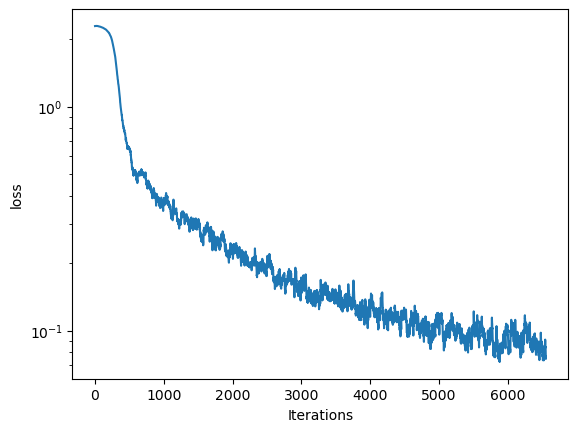

100%|██████████| 938/938 [00:11<00:00, 82.07it/s]

Epoch [7/7], Loss: 0.0000, Accuracy: 0.9724


{'web': 'https://www.comet.com/api/image/download?imageId=661e50b48f044ff8815c6ff071f814c7&experimentKey=5ff82e26b1fa40c7854e1a54d9bce210',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=661e50b48f044ff8815c6ff071f814c7&experimentKey=5ff82e26b1fa40c7854e1a54d9bce210',
 'imageId': '661e50b48f044ff8815c6ff071f814c7'}

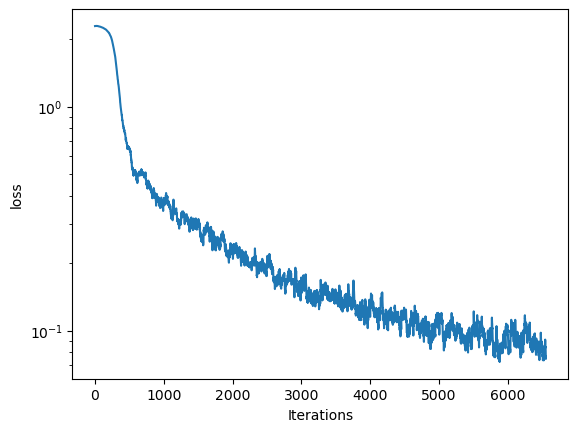

In [26]:
# Evaluate the model
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the elevation of loss
plotter = mdl.util.PeriodicPlotter(sec=2,xlabel ='Iterations',ylabel ='loss', scale= 'semilogy')

#Initialize new comet experiment
comet_ml.init(project_name="HLab3_CNN")
comet_model_2 = comet_ml.Experiment()

if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()  # Clear any existing tqdm instances to avoid conflicts

#Training loop!
cnn_model.train()

for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0

    for idx, (images, labels) in enumerate(tqdm(trainset_loader)):
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        logits = cnn_model(images)

        #computer the loss
        loss = loss_function(logits, labels)

        # Get the loss and log it to comet and the loss_history record
        loss_value = loss.item()
        comet_model_2.log_metric('loss', loss_value, step=idx)
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        # Backward pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Get the predicted and tally metrics
        predicted = torch.argmax(logits, dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)


    #computer metrics
    total_epoch_loss = total_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
comet_model_2.log_figure(figure=plt)


In [27]:
# Evaluate the CNN Model

test_loss, test_acc = evaluate(cnn_model, trainset_loader, loss_function)

print(f"Test Accuracy :{test_acc:.4f}")

Test Loss: 0.0803, Test Accuracy: 0.9756
Test Accuracy :0.9756
